##### import geopandas as gpd
import numpy as np
import pandas as pd

# Read the shapefile
shapefile_path = 'True_forest.shp'
mt_kenya_shape = gpd.read_file(shapefile_path)

# Assuming you have a DataFrame named 'fire_data' containing fire occurrences
# Load or create the DataFrame with latitude and longitude columns
fire_data = pd.read_csv('fire_archive_M-C61_414680.csv')
fire_data['acq_date']= pd.to_datetime(fire_data['acq_date'])
fire_data["year"] = fire_data["acq_date"].dt.year

# Define the extent and resolution of the meshgrid
xmin, ymin, xmax, ymax = mt_kenya_shape.total_bounds
resolution = 0.1  # Set the resolution of the meshgrid (spacing between grid points)

# Create meshgrid
lon_grid, lat_grid = np.meshgrid(np.arange(xmin, xmax, resolution),
                                  np.arange(ymin, ymax, resolution))

# Assign unique identifier to each grid cell
grid_indices = np.arange(1, len(lon_grid.flat) + 1).reshape(lon_grid.shape)

# Aggregate fire occurrences within each grid cell
aggregated_data = []

for i in range(lon_grid.shape[0]):
    for j in range(lon_grid.shape[1]):
        # Define the bounding box of the current grid cell
        lon_min = lon_grid[i, j]
        lon_max = lon_grid[i, j] + resolution
        lat_min = lat_grid[i, j]
        lat_max = lat_grid[i, j] + resolution

        # Filter fire occurrences within the current grid cell
        fires_within_cell = fire_data[
            (fire_data['latitude'] >= lat_min) & (fire_data['latitude'] < lat_max) &
            (fire_data['longitude'] >= lon_min) & (fire_data['longitude'] < lon_max)
        ]
        
        # Aggregate fire occurrences by year
        fire_counts_by_year = fires_within_cell['year'].value_counts().to_dict()
        fire_counts_by_year2 = fires_within_cell['year']
        
        # Perform aggregation
        count = len(fires_within_cell)  # Count of fire occurrences
        avg_bright_t31 = fires_within_cell['bright_t31'].mean()  # Average bright_t31 values
        avg_time = fires_within_cell['acq_time'].mean()  # Average time values

        # Append aggregated data to the list
        aggregated_data.append({
            'Latitude': lat_grid[i, j],
            'Longitude': lon_grid[i, j], 
            'grid_index': grid_indices[i, j],
            'count': count,
            'avg_bright_t31': avg_bright_t31,
            'avg_time': avg_time,
            'fire_counts_by_year': fire_counts_by_year,
            'fire_counts_by_year2':fire_counts_by_year2 
        })

# Convert aggregated data to DataFrame
aggregated_df = pd.DataFrame(aggregated_data)

# Output aggregated data as CSV file
aggregated_df.to_csv('aggregated_data_with_latlon.csv', index=False)
#aggregated_df.to_file("aggregated_dat_with_latlon.shp", index=False)


In [76]:
import pandas as pd
import ast  # To safely evaluate string literals as Python expressions

# Load the CSV file
file_path = 'aggregated_data_with_latlon.csv'
data = pd.read_csv(file_path)

# Convert 'fire_counts_by_year' from string representation of dictionary to actual dictionary
data['fire_counts_by_year'] = data['fire_counts_by_year'].apply(lambda x: ast.literal_eval(x))

# Function to expand each row's 'fire_counts_by_year' into a list of dictionaries, 
# each containing the year and the corresponding fire count
def expand_fire_counts(row):
    return [{'year': year, 'fire_count': count} for year, count in row['fire_counts_by_year'].items()]

# Apply the function to each row and then explode the dataframe to have a long format
data_long = data.copy()
data_long['year_fire_count'] = data.apply(expand_fire_counts, axis=1)
data_long = data_long.explode('year_fire_count').reset_index(drop=True)

# Extract 'year' and 'fire_count' from the dictionaries
data_long['year'] = data_long['year_fire_count'].apply(lambda x: x['year'] if pd.notnull(x) else None)
data_long['fire_count'] = data_long['year_fire_count'].apply(lambda x: x['fire_count'] if pd.notnull(x) else None)

# Drop the original 'fire_counts_by_year' and 'year_fire_count' columns as they're no longer needed
data_long.drop(['fire_counts_by_year', 'year_fire_count'], axis=1, inplace=True)

# Save the transformed dataframe to a new CSV file
output_file_path = 'transformed_fire_counts.csv'
data_long.to_csv(output_file_path, index=False)

#transformed_df = pd.DataFrame(data_long)

# Output aggregated data as CSV file
#transformed_df.to_csv('transformed_fire_counts.csv', index=False)


In [77]:
import geopandas as gpd
import libpysal as lp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from splot.esda import moran_scatterplot, lisa_cluster
from esda.moran import Moran_Local

from libpysal.weights.contiguity import Queen
from libpysal import examples
from esda.moran import Moran
from splot.esda import moran_scatterplot
from esda.moran import Moran_Local

%matplotlib inline



# Read the aggregated data with latitude and longitude
#aggregated_df = pd.read_csv('aggregated_data_with_latlon.csv')
#aggregated_df = gpd.read_file("aggregated_dat_with_latlon.shp")
aggregated_df =  pd.read_csv("transformed_fire_counts.csv")
#aggregated_shp = gpd.read_file('aggregated_data2.shp')

# Create a GeoDataFrame from the aggregated data
geometry = gpd.points_from_xy(aggregated_df['Longitude'], aggregated_df['Latitude'])
gdf = gpd.GeoDataFrame(aggregated_df, geometry=geometry)


In [120]:


#y = gdf['count'].values
#w = Queen.from_dataframe(gdf)
#w.transform = 'r'

In [86]:
#ggregated_df['fire_countr'] = pd.to_datetime(aggregated_df['fire_count'])
#ggregated_df['year']= pd.to_datetime(aggregated_df['year'])

In [96]:
import pandas as pd

# Assuming gdf is your GeoDataFrame and 'acq_date' is the column containing datetime objects
# Specify the year you want to count values for
desired_year = 2012

# Filter the DataFrame by the desired year
gdf_year = gdf[gdf['year'] == desired_year]

# Now calculate the count values for the specified year
count = gdf_year['fire_count'].values

# Continue with your code
y = count
w = Queen.from_dataframe(gdf_year)
w.transform = 'r'


C:\Users\DANIEL\AppData\Local\Temp\ipykernel_9176\2737332309.py:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf_year)


In [97]:
from esda.moran import Moran

w = Queen.from_dataframe(gdf_year)
moran = Moran(y, w)
moran.I

C:\Users\DANIEL\AppData\Local\Temp\ipykernel_9176\4241115782.py:3: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf_year)


0.4153858369474746

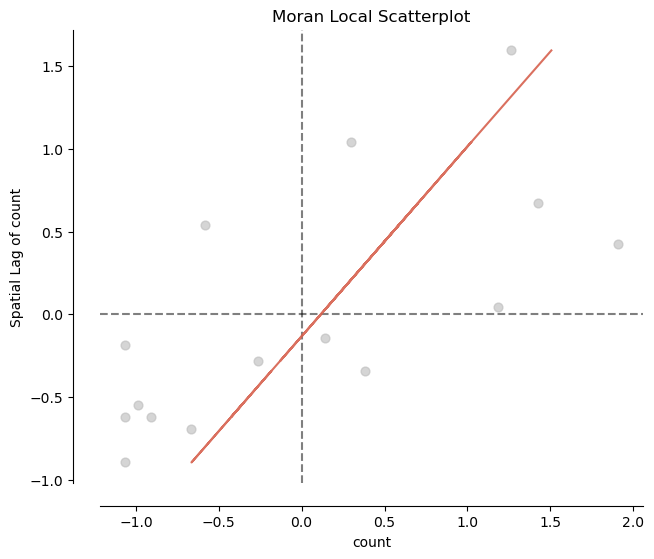

In [98]:
from splot.esda import moran_scatterplot
from esda.moran import Moran_Local

# calculate Moran_Local and plot
moran_loc = Moran_Local(y, w)
fig, ax = moran_scatterplot(moran_loc)
ax.set_xlabel('count')
ax.set_ylabel('Spatial Lag of count')
plt.show()

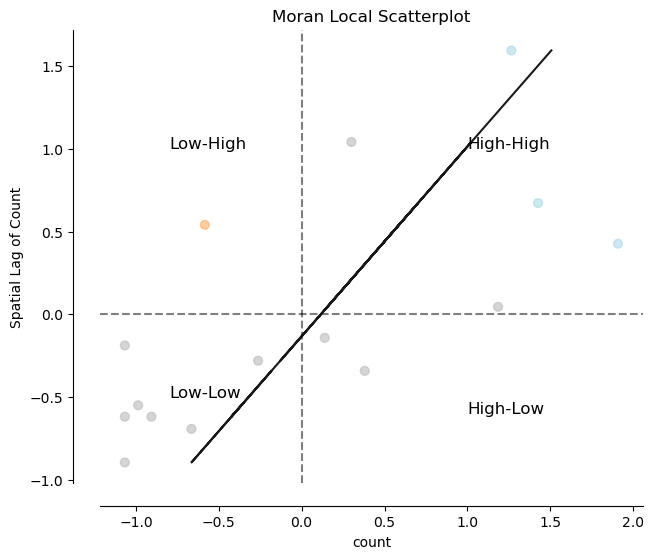

In [99]:
fig, ax = moran_scatterplot(moran_loc, p=0.05)
ax.set_xlabel('count')
ax.set_ylabel('Spatial Lag of Count')
plt.text(-0.8, 1, 'Low-High', fontsize=12)
plt.text(1, -0.6, 'High-Low', fontsize=12)
plt.text(-0.8, -0.5, 'Low-Low', fontsize=12)
plt.text(1, 1, 'High-High', fontsize=12)
plt.show()

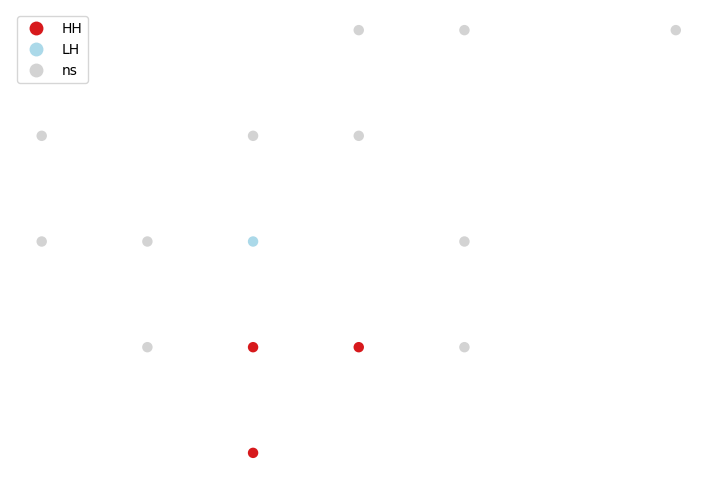

In [101]:
from splot.esda import lisa_cluster

lisa_cluster(moran_loc, gdf_year, p=0.05, figsize = (9,9))
plt.show()

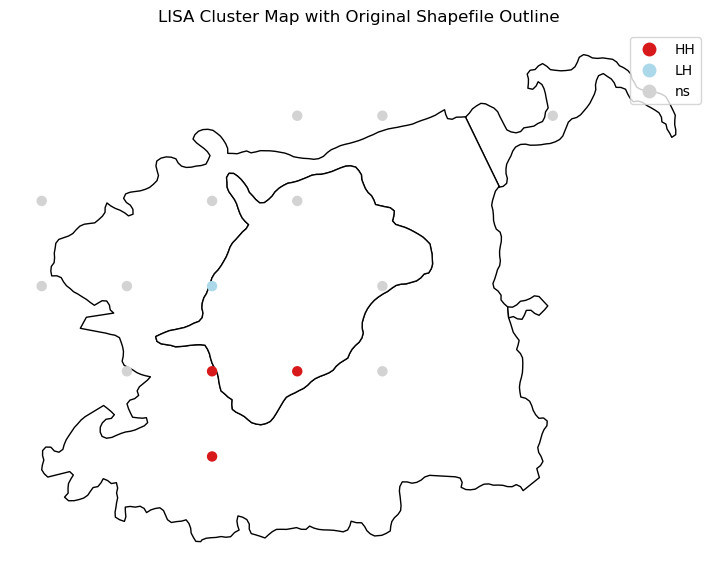

In [102]:
# Plot the original shapefile
fig, ax = plt.subplots(figsize=(9, 9))
mt_kenya_shape.plot(ax=ax, color='white', edgecolor='black')

# Plot the LISA cluster map
lisa_cluster(moran_loc, gdf_year, p=0.05, figsize=(9, 9), ax=ax)

plt.title('LISA Cluster Map with Original Shapefile Outline')
plt.show()

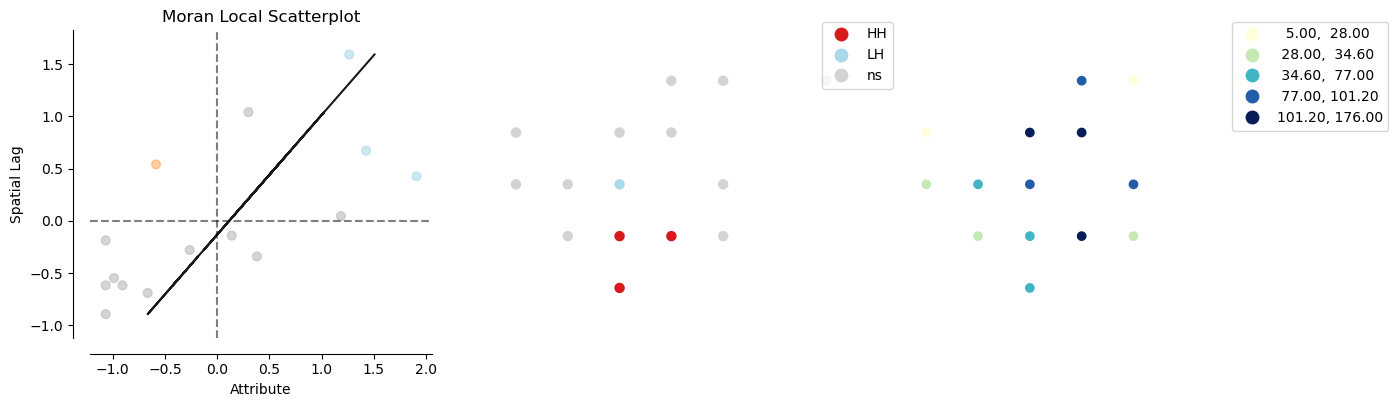

In [103]:
from splot.esda import plot_local_autocorrelation


plot_local_autocorrelation(moran_loc, gdf_year, 'count')
plt.show()

C:\Users\DANIEL\anaconda3\Lib\site-packages\splot\_viz_esda_mpl.py:1094: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  gpd.GeoSeries([union2]).plot(linewidth=1, ax=axs[1], color='#E5E5E5')
C:\Users\DANIEL\anaconda3\Lib\site-packages\splot\_viz_esda_mpl.py:1101: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  gpd.GeoSeries([union2]).plot(linewidth=1, ax=axs[2], color='#E5E5E5')


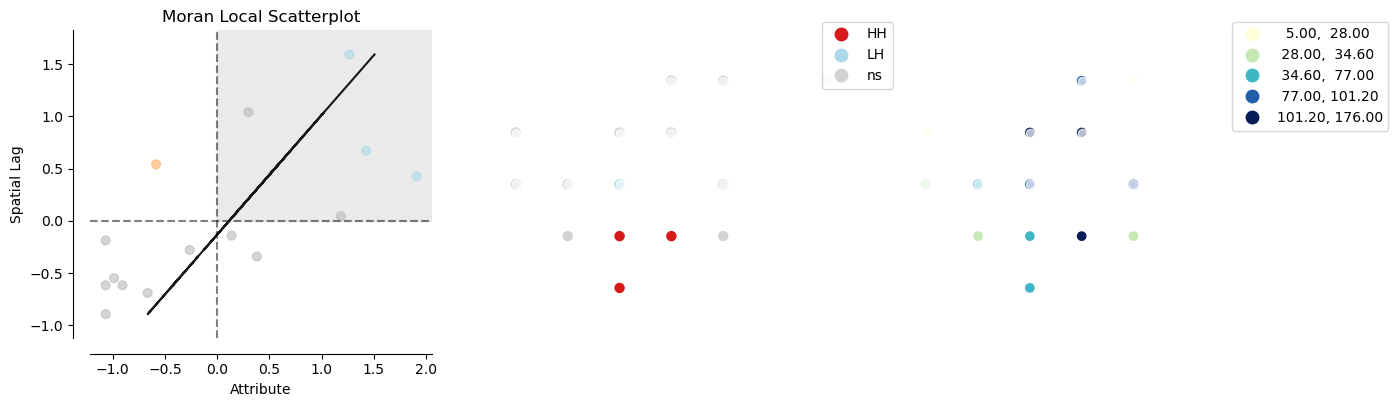

In [104]:
plot_local_autocorrelation(moran_loc, gdf_year, 'count', quadrant=1)
plt.show()

C:\Users\DANIEL\anaconda3\Lib\site-packages\splot\_viz_esda_mpl.py:1094: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  gpd.GeoSeries([union2]).plot(linewidth=1, ax=axs[1], color='#E5E5E5')
C:\Users\DANIEL\anaconda3\Lib\site-packages\splot\_viz_esda_mpl.py:1101: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  gpd.GeoSeries([union2]).plot(linewidth=1, ax=axs[2], color='#E5E5E5')


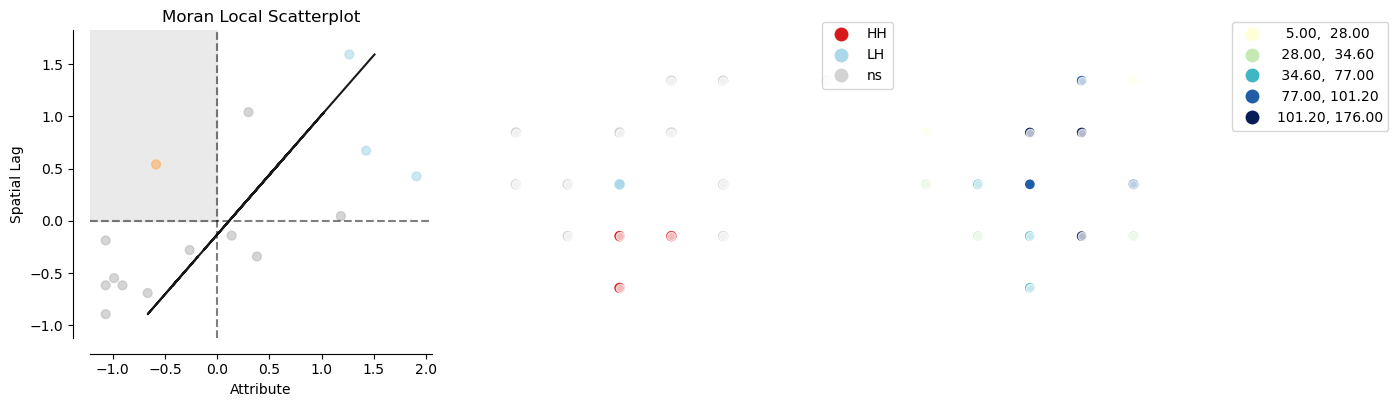

In [105]:
plot_local_autocorrelation(moran_loc, gdf_year, 'count', quadrant=2)
plt.show()

C:\Users\DANIEL\anaconda3\Lib\site-packages\splot\_viz_esda_mpl.py:1094: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  gpd.GeoSeries([union2]).plot(linewidth=1, ax=axs[1], color='#E5E5E5')
C:\Users\DANIEL\anaconda3\Lib\site-packages\splot\_viz_esda_mpl.py:1101: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  gpd.GeoSeries([union2]).plot(linewidth=1, ax=axs[2], color='#E5E5E5')


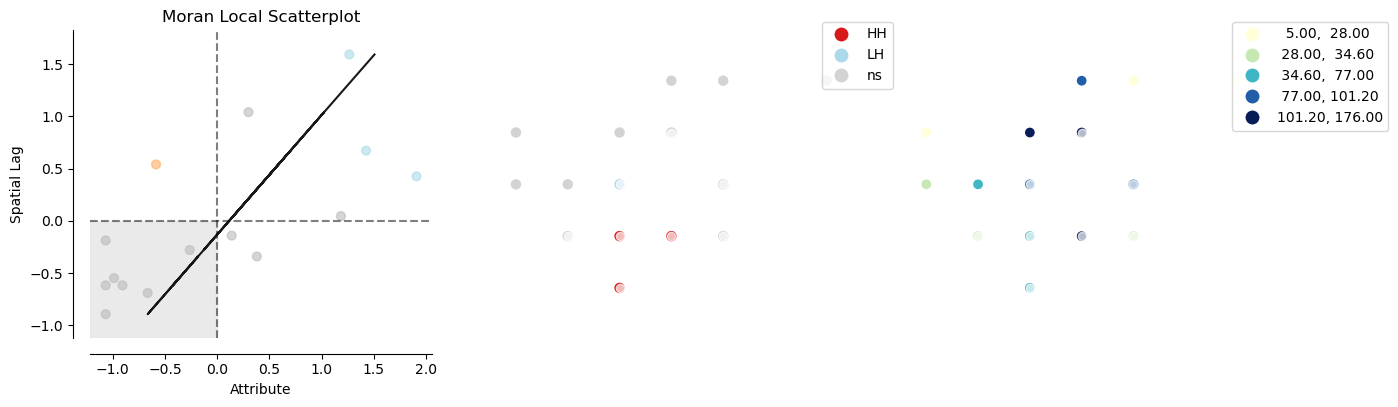

In [106]:
plot_local_autocorrelation(moran_loc, gdf_year, 'count', quadrant=3)
plt.show()

C:\Users\DANIEL\anaconda3\Lib\site-packages\splot\_viz_esda_mpl.py:1094: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  gpd.GeoSeries([union2]).plot(linewidth=1, ax=axs[1], color='#E5E5E5')
C:\Users\DANIEL\anaconda3\Lib\site-packages\splot\_viz_esda_mpl.py:1101: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  gpd.GeoSeries([union2]).plot(linewidth=1, ax=axs[2], color='#E5E5E5')


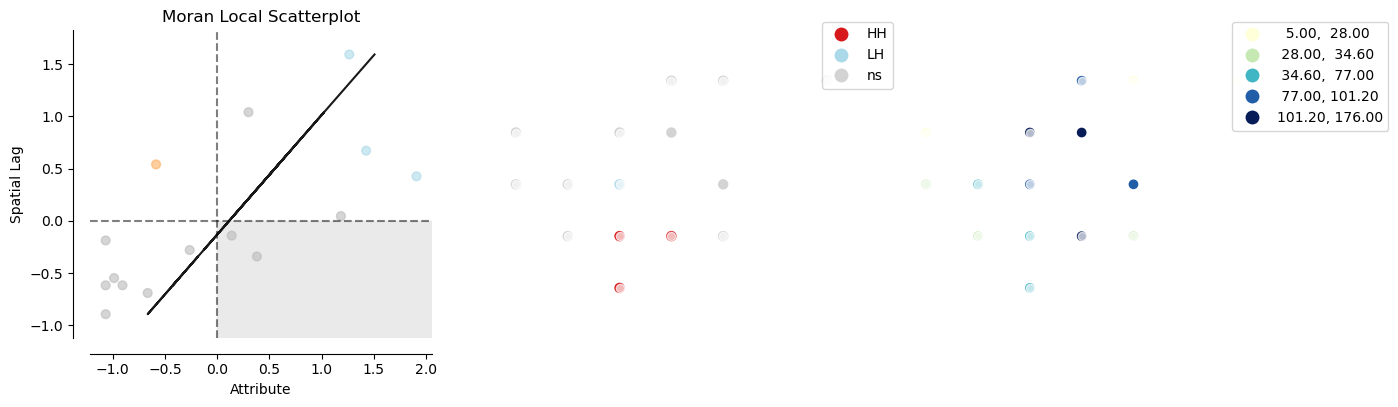

In [107]:
plot_local_autocorrelation(moran_loc, gdf_year, 'count', quadrant=4)
plt.show()

In [36]:
import pandas as pd
firerue = pd.read_csv('transformed_fire_counts.csv')

In [38]:
firerue = firerue.drop('fire_counts_by_year2',axis=1)


In [39]:
firerue

,Latitude,Longitude,grid_index,count,avg_bright_t31,avg_time,year,fire_count
0,-0.427146,37.047119,1,3,296.433333,1494.0,2003.0,1.0
1,-0.427146,37.047119,1,3,296.433333,1494.0,2006.0,1.0
2,-0.427146,37.047119,1,3,296.433333,1494.0,2015.0,1.0
3,-0.427146,37.147119,2,0,NaN,NaN,NaN,NaN
4,-0.427146,37.247119,3,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
211,0.072854,37.647119,47,6,299.266667,1148.0,2012.0,1.0
212,0.072854,37.647119,47,6,299.266667,1148.0,2016.0,1.0
213,0.072854,37.747119,48,4,301.200000,1140.0,2022.0,2.0
214,0.072854,37.747119,48,4,301.200000,1140.0,2004.0,1.0


In [125]:
firerue.groupby("year")
firerue#.set_index("year")

,Latitude,Longitude,grid_index,count,avg_bright_t31,avg_time,year,fire_count
0,-0.427146,37.047119,1,3,296.433333,1494.0,2003.0,1.0
1,-0.427146,37.047119,1,3,296.433333,1494.0,2006.0,1.0
2,-0.427146,37.047119,1,3,296.433333,1494.0,2015.0,1.0
3,-0.427146,37.147119,2,0,NaN,NaN,NaN,NaN
4,-0.427146,37.247119,3,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
211,0.072854,37.647119,47,6,299.266667,1148.0,2012.0,1.0
212,0.072854,37.647119,47,6,299.266667,1148.0,2016.0,1.0
213,0.072854,37.747119,48,4,301.200000,1140.0,2022.0,2.0
214,0.072854,37.747119,48,4,301.200000,1140.0,2004.0,1.0


In [110]:
import geopandas as gpd
import libpysal as lp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from splot.esda import moran_scatterplot, lisa_cluster
from esda.moran import Moran_Local

from libpysal.weights.contiguity import Queen
from libpysal import examples
from esda.moran import Moran
from splot.esda import moran_scatterplot
from esda.moran import Moran_Local

%matplotlib inline



# Read the aggregated data with latitude and longitude
#aggregated_df = pd.read_csv('aggregated_data_with_latlon.csv')
aggregated_df = gpd.read_file("aggregated_dat_with_latlon.shp")
#transformed_df =  pd.read_csv("transformed_fire_counts.csv")
#aggregated_shp = gpd.read_file('aggregated_data2.shp')

# Create a GeoDataFrame from the aggregated data
geometry = gpd.points_from_xy(aggregated_df['Latitude'], aggregated_df['Longitude'])
gdf = gpd.GeoDataFrame(aggregated_df, geometry=geometry)


In [111]:
y = gdf['count'].values
w = Queen.from_dataframe(gdf)
w.transform = 'r'

C:\Users\DANIEL\AppData\Local\Temp\ipykernel_9176\2079158519.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf)


In [112]:
import geopandas as gpd
import pandas as pd

# Read the CSV file into a DataFrame
transformed_df = pd.read_csv("transformed_fire_counts.csv")

# Check if the DataFrame has the columns 'Latitude' and 'Longitude'
if 'Latitude' in transformed_df.columns and 'Longitude' in transformed_df.columns:
    # Create a GeoDataFrame from the DataFrame by converting latitude and longitude to Point geometries
    geometry = gpd.points_from_xy(transformed_df['Longitude'], transformed

SyntaxError: incomplete input (3154344754.py, line 10)

In [113]:
import geopandas as gpd
import pandas as pd

# Read the CSV file into a DataFrame
transformed_fire = pd.read_csv("transformed_fire_counts.csv")

In [114]:
transformed_fire

,Latitude,Longitude,grid_index,count,avg_bright_t31,avg_time,fire_counts_by_year2,year,fire_count
0,-0.427146,37.047119,1,3,296.433333,1494.0,78 2003\n164 2006\n844 2015\nName: y...,2003.0,1.0
1,-0.427146,37.047119,1,3,296.433333,1494.0,78 2003\n164 2006\n844 2015\nName: y...,2006.0,1.0
2,-0.427146,37.047119,1,3,296.433333,1494.0,78 2003\n164 2006\n844 2015\nName: y...,2015.0,1.0
3,-0.427146,37.147119,2,0,NaN,NaN,"Series([], Name: year, dtype: int32)",NaN,NaN
4,-0.427146,37.247119,3,0,NaN,NaN,"Series([], Name: year, dtype: int32)",NaN,NaN
...,...,...,...,...,...,...,...,...,...
211,0.072854,37.647119,47,6,299.266667,1148.0,14 2001\n100 2004\n233 2006\n472 ...,2012.0,1.0
212,0.072854,37.647119,47,6,299.266667,1148.0,14 2001\n100 2004\n233 2006\n472 ...,2016.0,1.0
213,0.072854,37.747119,48,4,301.200000,1140.0,106 2004\n886 2016\n1307 2022\n1308...,2022.0,2.0
214,0.072854,37.747119,48,4,301.200000,1140.0,106 2004\n886 2016\n1307 2022\n1308...,2004.0,1.0


In [115]:
transformed_fire2 = transformed_fire.drop('fire_counts_by_year2', axis=1)

In [116]:
transformed_fire2

,Latitude,Longitude,grid_index,count,avg_bright_t31,avg_time,year,fire_count
0,-0.427146,37.047119,1,3,296.433333,1494.0,2003.0,1.0
1,-0.427146,37.047119,1,3,296.433333,1494.0,2006.0,1.0
2,-0.427146,37.047119,1,3,296.433333,1494.0,2015.0,1.0
3,-0.427146,37.147119,2,0,NaN,NaN,NaN,NaN
4,-0.427146,37.247119,3,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
211,0.072854,37.647119,47,6,299.266667,1148.0,2012.0,1.0
212,0.072854,37.647119,47,6,299.266667,1148.0,2016.0,1.0
213,0.072854,37.747119,48,4,301.200000,1140.0,2022.0,2.0
214,0.072854,37.747119,48,4,301.200000,1140.0,2004.0,1.0


In [117]:
transformed_fire2.groupby("year")

<Axes: xlabel='year'>

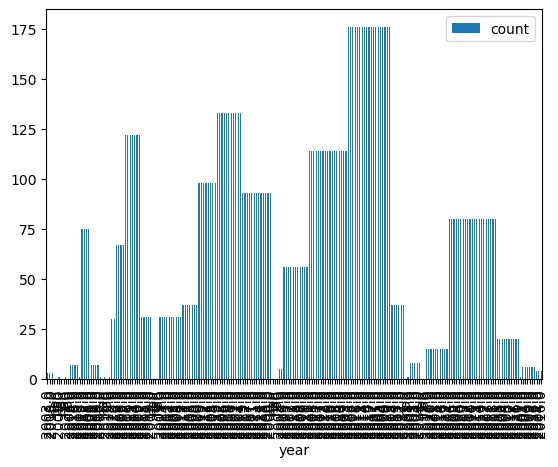

In [118]:
transformed_fire2.plot(x="year",y="count",kind="bar")